
# LoRaSim-AIM: simulate collisions in LoRa using the additive interference model
Extension to the original LoRaSim by Thiemo Voigt <thiemo@sics.se> and Martin Bor <m.bor@lancaster.ac.uk>

This work is licensed under the Creative Commons Attribution 4.0
International License. To view a copy of this license,
visit http://creativecommons.org/licenses/by/4.0/.

In [16]:
# import modules
import simpy
import random
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import os

===== Location generation =====
Max range = 823.920218138 at SF = 10, BW = 125
generated locations for 1 base-stations
generated locations for 8000 nodes


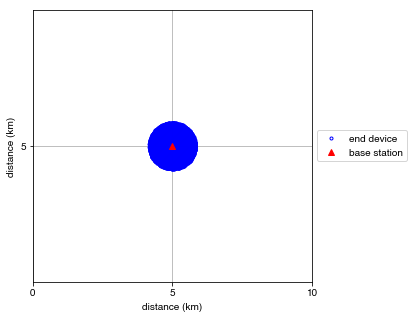

In [17]:
## Scaled down configuratons for testing purposes
avgSendTime = 1200000
simtime = 24*3600*1000 # time in ms
packetLength = 20 # in bytes

# define the maximum simulation area
maxX = 10000 # in m
maxY = 10000 # in m

# define other the number of nodes in the simulation
maxNrBS = 1
maxNrNodes = 8000

# log shadow model parameters
Ptx = 30 # in dBm
gamma = 2.2394
# d0 = 40.0 # in m
d0 = 40.0 # from drive tests
var = 0 # variance ignored for now. 
# Lpld0 = 127.41
Lpld0 = 95.0038 # from drive test
GL = 0
nSF = 6 # spreading factors available = 6

# useful log-distance model functions
interferenceThreshold = -150 # dBm
nSF = 6
nDemodulator = 8 # number of demodulators on base-station

def dBmTomW(pdBm):
    pmW = 10**(pdBm/10.0)
    return pmW

def getRXPower(pTX, distance):
    # get ideal RX power estimate assuming log-distance model
    pRX = pTX - Lpld0 - 10.0*gamma*np.log10(distance/d0)
    return pRX
    
def getTXPower(pRX, distance):
    # get ideal TX power estimate assuming log-distance model
    pTX = pRX + Lpld0 + 10.0*gamma*np.log10(distance/d0)
    return pTX

def getDistanceFromPL(pTX, pRX):
    d = d0*10**((pTX-pRX-Lpld0)/(10.0*gamma))
    return d

maxInterferenceDist = getDistanceFromPL(30, interferenceThreshold)

# this is an array with measured values for sensitivity
# see LoRa scaling paper, Table 1

# Note: different receiver hardware will have different values of sensitivity
# However, we assume these values are identical for all our base-stations

sf7 = np.array([7,-126.5,-124.25,-120.75])
sf8 = np.array([8,-127.25,-126.75,-124.0])
sf9 = np.array([9,-131.25,-128.25,-127.5])
sf10 = np.array([10,-132.75,-130.25,-128.75])
sf11 = np.array([11,-134.5,-132.75,-128.75])
sf12 = np.array([12,-133.25,-132.25,-132.25])

# array of sensitivity values
sensi = np.array([sf7,sf8,sf9,sf10,sf11,sf12])

# this is the spreading factor interaction matrix derived from lab tests and Semtech documentation
interactionMatrix = np.array([
    [dBmTomW(6), dBmTomW(-7), dBmTomW(-7), dBmTomW(-7), dBmTomW(-7), dBmTomW(-7)],
    [dBmTomW(-10), dBmTomW(6), dBmTomW(-10), dBmTomW(-10), dBmTomW(-10), dBmTomW(-10)],
    [dBmTomW(-12.5), dBmTomW(-12.5), dBmTomW(6), dBmTomW(-12.5), dBmTomW(-12.5), dBmTomW(-12.5)],
    [dBmTomW(-15), dBmTomW(-15), dBmTomW(-15), dBmTomW(6), dBmTomW(-15), dBmTomW(-15)],
    [dBmTomW(-17.5), dBmTomW(-17.5), dBmTomW(-17.5), dBmTomW(-17.5), dBmTomW(6), dBmTomW(-17.5)],
    [dBmTomW(-20), dBmTomW(-20), dBmTomW(-20), dBmTomW(-20), dBmTomW(-20), dBmTomW(6)]])

def airtime(sf,cr,pl,bw):
    H = 0        # implicit header disabled (H=0) or not (H=1)
    DE = 0       # low data rate optimization enabled (=1) or not (=0)
    Npream = 8   # number of preamble symbol (12.25  from Utz paper)

    if bw == 125 and sf in [11, 12]:
        # low data rate optimization mandated for BW125 with SF11 and SF12
        DE = 1
    if sf == 6:
        # can only have implicit header with SF6
        H = 1

    Tsym = (2.0**sf)/bw
    Tpream = (Npream + 4.25)*Tsym
    payloadSymbNB = 8 + max(math.ceil((8.0*pl-4.0*sf+28+16-20*H)/(4.0*(sf-2*DE)))*(cr+4),0)
    Tpayload = payloadSymbNB * Tsym
    return Tpream + Tpayload

def getUSMaxTransmitDistance(RXSensi, plen, logDistParams):
    """
    Based on the transmit time and bandwidth used, get the parameters which give the best range for allowed power.
    This is dependent on the packet length as the max transmission size is also limited.
    
    TODO: Similar functions should be defined for other regions.
    """
    # Allowed max power for each bandwidth in the US
    
    gamma, Lpld0, d0 = logDistParams
    
    PTx125 = 30 # in dBm
    PTx500 = 26 # in dBm
    
    # The US spec doesn't have a 250 kHz option (and there is no good reason to use it)
    Lpl125 = PTx125 - RXSensi[:,1]
    Lpl500 = PTx500 - RXSensi[:,3]
    
    LplMatrix = np.concatenate((Lpl125.reshape((6,1)), Lpl500.reshape((6,1))), axis=1)
    distMatrix = np.dot(d0, np.exp(np.divide(LplMatrix - Lpld0, 10*gamma)))
    
    packetAirtimeValid = np.zeros((6,2))
    for i in xrange(6):
        packetAirtimeValid[i,0] = (airtime(i+7, 1, plen, 125) <= 400)
        packetAirtimeValid[i,1] = (airtime(i+7, 1, plen, 500) <= 400)
        
    Index = np.argmax(np.multiply(distMatrix, packetAirtimeValid))
    
    sfInd, bwInd = np.unravel_index(Index, (6,2))
    
    if packetAirtimeValid[sfInd, bwInd] == 0:
        raise ValueError("packet length too large")
    
    maxSF = sfInd + 7
    if bwInd == 0:
        maxBW = 125
    else:
        maxBW = 500
    
    return distMatrix[sfInd,bwInd], maxSF, maxBW

BSLoc = np.zeros((maxNrBS, 5))
nodeLoc = np.zeros((maxNrNodes, 9))

bestDist, bestSF, bestBW = getUSMaxTransmitDistance(sensi, packetLength, (gamma, Lpld0, d0))

def placeRandomly(number, locArray, xRange, yRange):
    for n in xrange(number):
        x = random.uniform(xRange[0], xRange[1])
        y = random.uniform(yRange[0], yRange[1])
        locArray[n,:] = [n, x, y, 0, 0]
        
def placeRandomlyInRange(number, locArray, xRange, yRange, refLoc):
    for n in xrange(number):
#         rounds = 0
        while True:
            # This could technically turn into an infinite loop but that shouldn't ever practically happen.
            # add check here later
            x = random.uniform(xRange[0], xRange[1])
            y = random.uniform(yRange[0], yRange[1])
            if np.any(np.sum(np.square(refLoc[:,1:3] - np.array([x,y]).reshape(1,2)), axis=1) <= bestDist**2):
                locArray[n,:] = [n, x, y, 0, bestBW, bestSF, 1, 30, avgSendTime]
                break
        
print "===== Location generation ====="

# seed the random generator
random.seed(1)

print "Max range = {} at SF = {}, BW = {}".format(bestDist, bestSF, bestBW)

if maxNrBS == 1:
    BSLoc[0] = [0, maxX*0.5, maxY*0.5, 0, 0]
else:
    placeRandomly(maxNrBS, BSLoc, [maxX*0.1, maxX*0.9], [maxY*0.1, maxY*0.9])
print "generated locations for {} base-stations".format(maxNrBS)

placeRandomlyInRange(maxNrNodes, nodeLoc, [0, maxX], [0, maxY], BSLoc)
print "generated locations for {} nodes".format(maxNrNodes)

# np.save("bsList_bs{}_nodes{}.npy".format(maxNrBS, maxNrNodes), BSLoc)
# np.save("nodeList_bs{}_nodes{}.npy".format(maxNrBS, maxNrNodes), nodeLoc)

def plotLocations():
    loc_plot = plt.figure(figsize = (5,5))
    loc_ax = plt.gca()
    
    for b in BSLoc[:,1:3]:
        loc_ax.add_artist(plt.Circle((b[0], b[1]), bestDist, fill=False, hatch='//', color = 'red'))
    
    nodePoints, = plt.plot(nodeLoc[:,1], nodeLoc[:,2], "b.", mfc='none', label="end device")
    bsPoints, = plt.plot(BSLoc[:,1], BSLoc[:,2], "r^", label="base station")
    
    plt.xticks([0, 5000, 10000, 15000, 20000], [0,5,10,15,20])
    plt.yticks([0, 5000, 10000, 15000, 20000], [0,5,10,15,20])
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
    plt.axis('equal')
    plt.xlim((0, maxX))
    plt.ylim((0, maxY))
    
    plt.xlabel('distance (km)')
    plt.ylabel('distance (km)')
    
    plt.show()
    
plotLocations()

# Additive interference model

Two major additions from the commonly used Independent Interference model:

1. Interactions consider more than 2 packets at a time
2. We consider interactions between spreading factors for the same frequency (which are otherwise considered to be orthogonal)

All frequencies and references to freqencies in this formulation will be expressed in kHz.

## Spreading Factor Interactions

The interaction matrix between various spreading factors follows the following rules:

1. Same SF must have >6 dBm difference for the stronger packet to get through
2. Different SF's have varying requirements for for Interference + Noise given by (and based on Semtech webinar slides)
    - SF7: -7 dBm
    - SF8: -10 dBm
    - SF9: -12.5 dBm
    - SF10: -15 dBm
    - SF11: -17.5 dBm
    - SF12: -20 dBm
    
We can thus create an interaction matrix given by:

$$
M_{Intr}
=
\left(\begin{array}{cc} 
dBmTomW(6) & dBmTomW(-7) & dBmTomW(-7) & dBmTomW(-7) & dBmTomW(-7) & dBmTomW(-7) \\
dBmTomW(-10) & dBmTomW(6) & dBmTomW(-10) & dBmTomW(-10) & dBmTomW(-10) & dBmTomW(-10) \\
dBmTomW(-12.5) & dBmTomW(-12.5) & dBmTomW(6) & dBmTomW(-12.5) & dBmTomW(-12.5) & dBmTomW(-12.5) \\
dBmTomW(-15) & dBmTomW(-15) & dBmTomW(-15) & dBmTomW(6) & dBmTomW(-15) & dBmTomW(-15) \\
dBmTomW(-17.5) & dBmTomW(-17.5) & dBmTomW(-17.5) & dBmTomW(-17.5) & dBmTomW(6) & dBmTomW(-17.5) \\
dBmTomW(-20) & dBmTomW(-20) & dBmTomW(-20) & dBmTomW(-20) & dBmTomW(-20) & dBmTomW(6) \\
\end{array}\right)
=
\left(\begin{array}{cc}
 3.98107171 & 0.19952623 & 0.19952623 & 0.19952623 & 0.19952623 & 0.19952623 \\
 0.1        & 3.98107171 & 0.1        & 0.1        & 0.1        & 0.1        \\
 0.05623413 & 0.05623413 & 3.98107171 & 0.05623413 & 0.05623413 & 0.05623413 \\
 0.03162278 & 0.03162278 & 0.03162278 & 3.98107171 & 0.03162278 & 0.03162278 \\
 0.01778279 & 0.01778279 & 0.01778279 & 0.01778279 & 3.98107171 & 0.01778279 \\
 0.01       & 0.01       & 0.01       & 0.01       & 0.01       & 3.98107171 \\
\end{array}\right)
$$ 

If the power of a packet using Spreading factor $SF$ is given by $P$ and the additive power of the interference in each spreading factor is given by a vector $\mathbb{P}$, the packet is assumed to be successfully received if

$$ P > (M_{Intr} \mathbb{P})_{SF} $$

In [18]:
## This function needs to be redone for the new testing format
def getFreqBucketsFromSet(BSFreqSetList):
    ## This function gives a list of frequencies for various bandwidths used by our base-stations
    ## This is only applicable to the US 902-928 + white space specifications.
    ## Other regions would need their own functions
    
    freqSetList = np.unique(BSFreqSetList)
    freqBuckets = set()
    
    for i in freqSetList:
        if i < 8:
            freqBuckets.update(np.linspace(902300 + 200*8*i, 903700 + 200*8*i, 8, dtype=int))
        else:
            # assuming channel 5 is used for white spaces
            freqBuckets.update(np.linspace(72100 + 200*8*(i-8), 73700 + 200*8*(i-8), 8, dtype=int))

    return freqBuckets

class myBS_AIM():
    def __init__(self, bsid, position, fset, isRogue):
        self.bsid = bsid
        self.x, self.y = position
        self.fset = fset
        self.isRogue = isRogue
        
        self.packets = {}
            
        freqBuckets = getFreqBucketsFromSet(fset)
        self.packetsInBucket = {}
        self.signalLevel = {}
        for freq in freqBuckets:
            self.packetsInBucket[freq] = {}
            self.signalLevel[freq] = np.zeros((6,1))
        self.demodulator = set()
    
    def addPacket(self, nodeid, packet):
        """Send a packet to the base station"""
        for fbucket in packet.signalLevel.viewkeys():
            self.signalLevel[fbucket] = self.signalLevel[fbucket] + packet.signalLevel[fbucket]
            self.packetsInBucket[fbucket][nodeid] = packet
            self.evaluateFreqBucket(fbucket)
        self.packets[nodeid] = packet
    
    def removePacket(self, nodeid):
        """Stop sending a packet to the base station i.e. Remove it from all relevant lists"""
        pkt = self.packets[nodeid]
        # if packet was being demodulated, free the demodulator
        if pkt.isCritical and (pkt.fc, pkt.bw, pkt.sf) in self.demodulator:
            # only successfully demodulated packets i.e. Those that are critical are considered to be received
            self.demodulator.remove((pkt.fc, pkt.bw, pkt.sf))
        for fbucket in pkt.signalLevel.viewkeys():
            self.signalLevel[fbucket] = self.signalLevel[fbucket] - pkt.signalLevel[fbucket]
            foo = self.packetsInBucket[fbucket].pop(nodeid)
        foo = self.packets.pop(nodeid)
        return pkt.isCritical and not pkt.isLost
            
    
    def makeCritical(self, nodeid):
        """Packet from node enters critical section"""
        pkt = self.packets[nodeid]
        if not pkt.isLost:
            if self.evaluatePacket(nodeid) and len(self.demodulator) <= nDemodulator and (pkt.fc, pkt.bw, pkt.sf) not in self.demodulator:
                self.demodulator.add((pkt.fc, pkt.bw, pkt.sf))
                pkt.isCritical = True
            else:
                pkt.isLost = True
                pkt.isCritical = False
    
#     def evaluateFreqBucket(self, fbucket):
# #         signalInBucket = np.dot(interactionMatrix, self.signalLevel[fbucket])
#         for nodeid, pkt in self.packetsInBucket[fbucket].viewitems():
#             if not pkt.isLost and pkt.isCritical:
#                 signalInBucket = np.dot(interactionMatrix[pkt.sf - 7].reshape(1,6), self.signalLevel[fbucket] - pkt.signalLevel[fbucket])
#                 if (pkt.signalLevel[fbucket][pkt.sf - 7]) < signalInBucket:
# #                 if (2 + dBmTomW(6))*(pkt.signalLevel[fbucket][pkt.sf - 7]) < signalInBucket[pkt.sf - 7]:
#                     pkt.isLost = True
    
#     def evaluatePacket(self, nodeid):
#         pkt = self.packets[nodeid]
#         if pkt.isLost:
#             return False
#         else:
#             successFlag = True
#             for fbucket,pktSignal in pkt.signalLevel.viewitems():
#                 signalInBucket = np.dot(interactionMatrix[pkt.sf - 7].reshape(1,6), self.signalLevel[fbucket] - pktSignal)
#                 if (pkt.signalLevel[fbucket][pkt.sf - 7]) < signalInBucket:
# #                 if (2 + dBmTomW(6))*(pkt.signalLevel[fbucket][pkt.sf - 7]) < signalInBucket:
#                     successFlag = False
#             return successFlag
    
    def evaluateFreqBucket(self, fbucket):
        signalInBucket = np.dot(interactionMatrix, self.signalLevel[fbucket])
        for nodeid, pkt in self.packetsInBucket[fbucket].viewitems():
            if not pkt.isLost and pkt.isCritical:
#             if not pkt.isLost:
                if (1 + dBmTomW(6))*(pkt.signalLevel[fbucket][pkt.sf - 7]) < signalInBucket[pkt.sf - 7]:
#                 if (dBmTomW(6))*(pkt.signalLevel[fbucket][pkt.sf - 7]) < signalInBucket[pkt.sf - 7]:
                    pkt.isLost = True
    
    def evaluatePacket(self, nodeid):
        pkt = self.packets[nodeid]
        if pkt.isLost:
            return False
        else:
            lostFlag = False
            for fbucket in pkt.signalLevel.viewkeys():
                signalInBucket = np.dot(interactionMatrix[pkt.sf - 7].reshape(1,6), self.signalLevel[fbucket])
                if (1 + dBmTomW(6))*(pkt.signalLevel[fbucket][pkt.sf - 7]) < signalInBucket:
#                 if (dBmTomW(6))*(pkt.signalLevel[fbucket][pkt.sf - 7]) < signalInBucket:
                    lostFlag = True
            return not lostFlag
            
class myPacket_AIM():
    def __init__(self, nodeid, bsid, dist, fset, bw, sf, cr, pTX):
        self.nodeif = nodeid
        self.bsid = bsid
        self.dist = dist
        self.fset = fset
        self.bw = bw
        self.sf = sf
        self.cr = cr
        self.pTX = pTX
        self.pRX = getRXPower(pTX, self.dist)
        self.signalLevel = None
        self.hoppingSequence = self.generateHoppingSequence()
        self.fc = None
        self.packetNumber = 0
        
        self.isLost = False
        self.isCritical = False
        
    def computePowerDist(self):
        global bsDict
        signalLevel = self.getPowerContribution()
        signalLevel = {x:signalLevel[x] for x in signalLevel.viewkeys() & bsDict[self.bsid].signalLevel.viewkeys()}
        return signalLevel
        
    def updateTXSettings(self, seedNo):
        self.packetNumber += 1
        self.fc = self.hoppingSequence[seedNo % len(self.hoppingSequence)]
        self.signalLevel = self.computePowerDist()
        
        if self.pRX >= sensi[self.sf-7, 1+int(self.bw/250)]:
            self.isLost = False
        else:
            self.isLost = True
            
        self.isCritical = False
        
    def getAffectedFreqBuckets(self):
        """This funtion returns a list of affected buckets"""

        low = self.fc - self.bw/2 # Note: this is approx due to integer division for 125
        high = self.fc + self.bw/2 # Note: this is approx due to integer division for 125
        lowBucketStart = low - (low % 200) + 100
        highBucketEnd = high + 200 - (high % 200) - 100

        # the +1 ensures that the last value is included in the set
        return xrange(lowBucketStart, highBucketEnd + 1, 200)

    def getPowerContribution(self):
        """This function should return the power contribution of a packet in various frequency buckets"""
        freqBuckets = self.getAffectedFreqBuckets()
        nBuckets = len(freqBuckets)

        powermW = dBmTomW(self.pRX)
        if nBuckets == 1:
            # this is the most common case with 125 kHz BW in the center of the bucket
            signal = np.zeros((nSF,1))
            signal[self.sf-7] = powermW
            return {freqBuckets[0]:signal}
        elif nBuckets == 4 and self.fc == freqBuckets[0] + 300:
            # this is the second most common case with 500 kHz BW spread between 4 channels
            signalDict = {}
            for i,freq in enumerate(freqBuckets):
                signal = np.zeros((nSF,1))
                if i == 0 or i == 3:
                    signal[self.sf-7] = 0.1 * powermW
                else:
                    signal[self.sf-7] = 0.4 * powermW
                signalDict[freq] = signal
            return signalDict
        else:
            raise NotImplementedError("non-centered frequencies and 250 kHz not implemented")
            
    def generateHoppingSequence(self):
        
        freqSetList = np.unique(self.fset)
        freqBuckets = []
        if self.bw == 125:
            for i in freqSetList:
                if i < 8:
                    freqBuckets.extend(np.linspace(902300 + 200*8*i, 903700 + 200*8*i, 8, dtype=int))
                else:
                    # assuming channel 5 is used for white spaces
                    freqBuckets.extend(np.linspace(72100 + 200*8*(i-8), 73700 + 200*8*(i-8), 8, dtype=int))
            
        elif self.bw == 500:
            if self.fset < 8:
                freqBuckets.extend([903000 + 1600*i])
            else:
                # white space
                freqBuckets.extend([72900 + 1600*(i-8)])
                pass
            
        return np.random.permutation(freqBuckets)
    
class myNode_AIM():
    def __init__(self, nodeid, position, fset, bw, sf, cr, pTX, period, bsList):
        self.nodeid = nodeid
        self.x, self.y = position
        self.fset = fset
        self.bw = bw
        self.sf = sf
        self.cr = cr
        self.pTX = pTX
        self.period = period
        self.packetNumber = 0
        
        # counters for performance metrics
        self.packetsTransmitted = 0
        self.packetsSuccessful = 0
        
        self.proximateBS = self.generateProximateBS(bsList)
        self.packets = self.generatePacketsToBS()
            
    def generateProximateBS(self, bsList):
        # generate dictionary of base-stations in proximity
        maxInterferenceDist = getDistanceFromPL(self.pTX, interferenceThreshold)
        dist = np.sqrt((bsList[:,1] - self.x)**2 + (bsList[:,2] - self.y)**2)
        index = np.nonzero(dist <= maxInterferenceDist)

        proximateBS = {} # create empty dictionary
        for i in index[0]:
            proximateBS[int(bsList[i,0])] = dist[i]

        return proximateBS
    
    def generatePacketsToBS(self):
        packets = {} # empty dictionary to store packets originating at a node
        
        for bsid, dist in self.proximateBS.viewitems():
            packets[bsid] = myPacket_AIM(self.nodeid, bsid, dist, self.fset, self.bw, self.sf, self.cr, self.pTX)
            
        return packets
    
    def updateTXSettings(self):
        pass

    
def transmitPacket(env, node, bsDict):
    # this assumed the radio assignemnts for a node are static, and do not change later
    # We select a given static assignment in the whole network
    
    while True:
        # The inter-packet waiting time. Assumed to be exponential here.
        yield env.timeout(random.expovariate(1.0/float(node.period)))
        
        # update settings if any
        node.updateTXSettings()
        
        node.packetNumber += 1
        # send a virtual packet to each base-station in range and those we may affect
        for bsid, dist in node.proximateBS.viewitems():
            node.packets[bsid].updateTXSettings(node.packetNumber)
            bsDict[bsid].addPacket(node.nodeid, node.packets[bsid])
            
        Npreamb = 8 # assuming 8 preamble symbols
        Tcritical = (2**node.sf/node.bw)*(Npreamb - 5) # time until the start of the critical section
        
        # wait until critical section starts
        yield env.timeout(Tcritical)
        
        # make the packet critical on all nearby basestations
        for bsid in node.proximateBS.viewkeys():
            bsDict[bsid].makeCritical(node.nodeid)
            
        Trest = airtime(node.sf, node.cr, packetLength, node.bw) - Tcritical # time until the rest of the message completes
        
        yield env.timeout(Trest)
        
#         print "packet complete"
        
        successfulRx = False
        for bsid in node.proximateBS.viewkeys():
#             print "eval bs {}".format(bsid)
            if bsDict[bsid].removePacket(node.nodeid):
                successfulRx = True
                
        node.packetsTransmitted += 1
        if successfulRx:
            node.packetsSuccessful += 1
            
#         print "packet done"

def cuckooClock(env):
    while True:
        yield env.timeout(3600000)
#         print "Cuckoo! {} Hrs".format(env.now/(3600000))

In [19]:
# simSetting = list(np.linspace(100,2000,20,endpoint = True, dtype=int))

# simSetting = list(np.linspace(200,2000,5,endpoint = True, dtype=int))

simSetting = [250, 500, 1000, 2000, 4000, 8000]

nTransmitted = []
nRecvd = []

for i,n in enumerate(simSetting):

    BSList = BSLoc[0:n,:]
    nodeList = nodeLoc[0:n,:]
    
    print "===== Setup parameters ====="
#     print "grid size = {} m x {} m".format(maxX, maxY)
    print "# base-stations = {}".format(maxNrBS)
    print "# nodes = {}".format(n)
#     print "minimum sensitivity (dBm) = {}".format(np.amin(sensi))
    env = simpy.Environment()

    env.process(cuckooClock(env))

    bsDict = {} # setup empty dictionary for base-stations
    for elem in BSList:
        bsDict[int(elem[0])] = myBS_AIM(int(elem[0]), (elem[1], elem[2]), int(elem[3]), bool(elem[4]))

    nodeDict = {} # setup empty dictionary for nodes
    for elem in nodeList:
        node = myNode_AIM(int(elem[0]), (elem[1], elem[2]), int(elem[3]), int(elem[4]), int(elem[5]), int(elem[6]), elem[7], elem[8], BSList)
        nodeDict[node.nodeid] = node
        env.process(transmitPacket(env, node, bsDict))

    env.run(until=simtime)

    nTransmitted.append(0)
    nRecvd.append(0)
    for nodeid, node in nodeDict.viewitems():
        nTransmitted[i] += node.packetsTransmitted
        nRecvd[i] += node.packetsSuccessful
        
    print "# Transmitted = {}".format(nTransmitted[i])
    print "# Received = {}".format(nRecvd[i])

===== Setup parameters =====
# base-stations = 1
# nodes = 250
# Transmitted = 17890
# Received = 17592
===== Setup parameters =====
# base-stations = 1
# nodes = 500
# Transmitted = 35883
# Received = 34639
===== Setup parameters =====
# base-stations = 1
# nodes = 1000
# Transmitted = 71899
# Received = 67146
===== Setup parameters =====
# base-stations = 1
# nodes = 2000
# Transmitted = 144207
# Received = 125315
===== Setup parameters =====
# base-stations = 1
# nodes = 4000
# Transmitted = 288680
# Received = 219748
===== Setup parameters =====
# base-stations = 1
# nodes = 8000
# Transmitted = 575998
# Received = 334719


Transmitted [17890, 35883, 71899, 144207, 288680, 575998]
Received [17592, 34639, 67146, 125315, 219748, 334719]
Ratio [ 0.98334265  0.96533177  0.93389338  0.86899388  0.76121657  0.58111139]


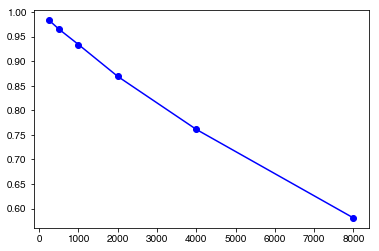

In [20]:
successRatio = np.array(nRecvd, dtype=float)/np.array(nTransmitted,dtype=float)
print "Transmitted {}".format(nTransmitted)
print "Received {}".format(nRecvd)

print "Ratio {}".format(successRatio)

def plotAIMPacketReception():
    
#     print totalReceived
#     print totalTransmitted
    
#     print np.divide(np.array(totalReceived, dtype=float), np.array(totalTransmitted, dtype=float))

    aimDerPlot = plt.figure()
    plt.plot(simSetting, successRatio, 'bo-')
#     plt.plot(simSetting, np.divide(np.array(totalCollided, dtype=float), np.array(totalTransmitted, dtype=float)), 'ro-')
    plt.show()
    
plotAIMPacketReception()